load the dataset

In [36]:
!pip install --quiet ONE-api ibllib

from one.api import ONE
import numpy as np

ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

# Get dataset for behavior trials
datasets = one.alyx.rest('datasets', 'list',
                         tag='2021_Q1_IBL_et_al_Behaviour',
                         name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])
print(f"Found {len(subjects)} subjects.")


Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
Found 140 subjects.


subject selection # i used the one subject only i train the model on all the subject which has biasedchoiceworld but i don't understand why the resulting session is less

In [37]:
# Pick first subject (or loop over more later)
subject = "ibl_witten_12"
print(f"Loading data for subject: {subject}")

subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')

# Merge trial data with session metadata
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop(columns='task_protocol')

subject_trials = subject_trials.set_index('session').join(
    session_trials.drop(columns=['date'], errors='ignore')
)
n_sessions = subject_trials.index.nunique()
print(f"Subject {subject} has {n_sessions} sessions.")


Loading data for subject: ibl_witten_12
Subject ibl_witten_12 has 92 sessions.


In [ ]:
Visualisation

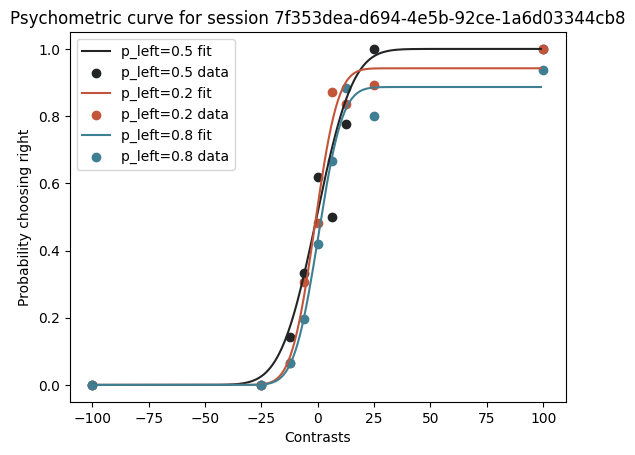

Session 7f353dea-d694-4e5b-92ce-1a6d03344cb8 — Trials: 769, Easy trial performance: 0.99


/usr/local/lib/python3.11/dist-packages/brainbox/behavior/training.py:561: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sum(trials['feedbackType'][easy_trials] == 1) / easy_trials.shape[0]


In [38]:
import matplotlib.pyplot as plt
from brainbox.behavior.training import plot_psychometric, compute_n_trials, compute_performance_easy

# Filter for biasedChoiceWorld sessions
bcw_sessions = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld', na=False)]
if len(bcw_sessions) == 0:
    raise RuntimeError("No biasedChoiceWorld sessions found for this subject.")

# Pick first session
sess_id = bcw_sessions.index.unique()[0]
trials = subject_trials.loc[sess_id]

plot_psychometric(trials)
plt.title(f"Psychometric curve for session {sess_id}")
plt.show()

# Print basic stats
n_trials = compute_n_trials(trials)
perf_easy = compute_performance_easy(trials)
print(f"Session {sess_id} — Trials: {n_trials}, Easy trial performance: {perf_easy:.2f}")


In [39]:
from brainbox.behavior.training import compute_performance

results = []
for sess_id in bcw_sessions.index.unique():
    trials = subject_trials.loc[sess_id]
    try:
        perf = compute_performance(trials)
        results.append({'session': sess_id, 'performance': perf})
    except Exception as e:
        print(f"Skipping session {sess_id} due to error: {e}")

# Convert to DataFrame for analysis
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


                                 session  \
0   7f353dea-d694-4e5b-92ce-1a6d03344cb8   
1   a2918467-d0d1-4217-8501-421f59c45881   
2   49e723cc-80c4-4f5e-8a45-9ca36a8564bc   
3   2423fd1a-873d-4b4a-81e8-d2f0046fd9ab   
4   b3f56eae-4665-49b7-9782-cb6c5211e0b2   
..                                   ...   
78  6a213250-c709-47c0-9015-001ee085f01a   
79  bcf27240-8d50-4480-95a2-02d24aa5ea8d   
80  0a376083-6e64-4a0b-908a-ec32a084748c   
81  14a03fbd-ba69-4d44-a901-39d86529a3be   
82  05d5fc29-19b5-40e1-b484-0b2040148bde   

                                          performance  
0   ([1.0, 1.0, 0.926829268292683, 0.7654320987654...  
1   ([1.0, 0.9710144927536232, 0.9438202247191011,...  
2   ([1.0, 1.0, 0.9538461538461539, 0.884892086330...  
3   ([0.9583333333333334, 1.0, 0.9354838709677419,...  
4   ([0.9897959183673469, 0.956140350877193, 0.959...  
..                                                ...  
78  ([1.0, 0.9433962264150944, 0.864406779661017, ...  
79  ([0.883928571428571

just random try

In [ ]:
subjects = ['KS024', 'DY_008', 'KS025', 'ZM_2107', 'CSHL_010']
for subject in subjects:
    sessions = one.alyx.rest('sessions', 'list', task_protocol='biasedChoiceWorld', subject=subject)
    print(f'Subject {subject} has {len(sessions)} biasedChoiceWorld sessions')


Subject KS024 has 30 biasedChoiceWorld sessions
Subject DY_008 has 17 biasedChoiceWorld sessions
Subject KS025 has 10 biasedChoiceWorld sessions
Subject ZM_2107 has 26 biasedChoiceWorld sessions
Subject CSHL_010 has 10 biasedChoiceWorld sessions


In [ ]:
# Get all sessions with biasedChoiceWorld task
all_sessions = one.alyx.rest('sessions', 'list', task_protocol='biasedChoiceWorld')

# Extract unique subjects from these sessions
subjects = np.unique([sess['subject'] for sess in all_sessions])

# Count biasedChoiceWorld sessions per subject
subject_session_counts = {}
for subj in subjects:
    subj_sessions = [sess for sess in all_sessions if sess['subject'] == subj]
    subject_session_counts[subj] = len(subj_sessions)

# Print results
print("Number of biasedChoiceWorld sessions per subject:")
for subj, count in subject_session_counts.items():
    print(f"{subj}: {count}")

# Find subject with max sessions
max_subject = max(subject_session_counts, key=subject_session_counts.get)
max_count = subject_session_counts[max_subject]
print(f"\nSubject with the most biasedChoiceWorld sessions: {max_subject} ({max_count} sessions)")

Number of biasedChoiceWorld sessions per subject:
CSHL045: 23
CSHL046: 26
CSHL047: 20
CSHL049: 17
CSHL051: 29
CSHL052: 15
CSHL053: 18
CSHL054: 32
CSHL055: 25
CSHL058: 4
CSHL059: 12
CSHL060: 18
CSHL_001: 12
CSHL_002: 13
CSHL_003: 11
CSHL_005: 2
CSHL_007: 13
CSHL_008: 6
CSHL_010: 10
CSHL_011: 1
CSHL_012: 40
CSHL_013: 1
CSHL_014: 55
CSHL_015: 49
CSH_ZAD_001: 26
CSH_ZAD_002: 33
CSH_ZAD_003: 14
CSH_ZAD_004: 14
CSH_ZAD_005: 30
CSH_ZAD_006: 7
CSH_ZAD_007: 12
CSH_ZAD_010: 11
CSH_ZAD_011: 26
CSH_ZAD_022: 3
DY_001: 3
DY_002: 3
DY_003: 3
DY_005: 15
DY_006: 26
DY_007: 24
DY_008: 17
DY_009: 11
DY_010: 34
DY_011: 39
DY_013: 16
DY_014: 4
IBL-T1: 39
IBL-T2: 33
IBL-T3: 34
IBL-T4: 41
IBL_001: 5
IBL_002: 17
IBL_005: 2
KS002: 24
KS004: 21
KS005: 21
KS014: 30
KS015: 29
KS016: 26
KS017: 30
KS018: 1
KS019: 65
KS021: 41
KS022: 25
KS023: 27
KS024: 30
KS025: 10
NYU-01: 51
NYU-02: 53
NYU-04: 52
NYU-06: 46
NYU-07: 7
NYU-09: 43
NYU-11: 20
NYU-12: 14
NYU-13: 23
NYU-14: 28
NYU-20: 22
SWC_001: 26
SWC_002: 1
SWC_013: 

boredom score computation

In [40]:
import pandas as pd
import numpy as np
from brainbox.behavior.training import compute_performance

def compute_disengagement_features(trials_df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes disengagement features for a single session of trials.
    Assumes trials_df is already filtered for a single session.
    """
    features = {}
    # 1. Reaction Time
    if 'response_times' in trials_df.columns:
        rt = trials_df['response_times']
        features['reaction_time_mean'] = rt.mean()
        features['reaction_time_std'] = rt.std()
    else:
        features['reaction_time_mean'] = np.nan
        features['reaction_time_std'] = np.nan

    # 2. Delay between trials (mean ITI)
    if 'intervals' in trials_df.columns:
        start_times = trials_df['intervals'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else np.nan)
        start_times = pd.to_numeric(start_times, errors='coerce')
        delays = start_times.diff().dropna()
        features['delay_between_trials_mean'] = delays.mean()
        features['delay_between_trials_std'] = delays.std()
    else:
        features['delay_between_trials_mean'] = np.nan
        features['delay_between_trials_std'] = np.nan

    # 3. Trials per session block (e.g., divide session into thirds)
    total_trials = len(trials_df)
    block_size = total_trials // 3
    features['trials_per_block'] = block_size

    # 4. Performance drop (first third vs last third)
    try:
        first_block = trials_df.iloc[:block_size]
        last_block = trials_df.iloc[-block_size:]
        perf_first = compute_performance(first_block)
        perf_last = compute_performance(last_block)
        features['performance_drop'] = perf_first - perf_last
    except Exception:
        features['performance_drop'] = np.nan

    return pd.Series(features)


In [41]:
feature_list = []
for sess_id in bcw_sessions.index.unique():
    session_trials = subject_trials.loc[sess_id]

    try:
        features = compute_disengagement_features(session_trials)
        features['session'] = sess_id
        feature_list.append(features)
    except Exception as e:
        print(f"Skipping session {sess_id} due to error: {e}")

disengagement_df = pd.DataFrame(feature_list)
print(disengagement_df.head())


   reaction_time_mean  reaction_time_std  delay_between_trials_mean  \
0         1680.391889         980.625591                        NaN   
1         2007.481716        1180.945991                        NaN   
2         2573.816310        1585.859421                        NaN   
3         2073.591546        1261.157559                        NaN   
4         2261.450491        1353.763930                        NaN   

   delay_between_trials_std  trials_per_block  performance_drop  \
0                       NaN             256.0               NaN   
1                       NaN             298.0               NaN   
2                       NaN             396.0               NaN   
3                       NaN             308.0               NaN   
4                       NaN             317.0               NaN   

                                session  
0  7f353dea-d694-4e5b-92ce-1a6d03344cb8  
1  a2918467-d0d1-4217-8501-421f59c45881  
2  49e723cc-80c4-4f5e-8a45-9ca36a8564bc  
3 

In [42]:
print(f"Original rows: {len(disengagement_df)}")
clean_df = disengagement_df.dropna()
print(f"Rows after dropping NaNs: {len(clean_df)}")

Original rows: 83
Rows after dropping NaNs: 0


In [43]:
print(disengagement_df.isna().sum())

reaction_time_mean            0
reaction_time_std             0
delay_between_trials_mean    83
delay_between_trials_std     83
trials_per_block              0
performance_drop             83
session                       0
dtype: int64


Model architecture and training

In [45]:
# Use only the features that are fully available
available_features = ['reaction_time_mean', 'reaction_time_std', 'trials_per_block']
df = disengagement_df[available_features + ['session']].copy()

# For demo purposes, let's create a fake 'boredom_score' to train on
# Later you can replace this with actual disengagement labels
np.random.seed(42)
df['boredom_score'] = np.random.uniform(0, 1, len(df))

# Train/test split
from sklearn.model_selection import train_test_split
X = df[available_features]
y = df['boredom_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize and train model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")


Test MAE: 0.2741


just random try which model performs better

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Linear Regression (with scaled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression Test MAE: {mae_lr:.4f}")

# Random Forest Regressor (on raw data)
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest Test MAE: {mae_rf:.4f}")


Linear Regression Test MAE: 0.2741
Random Forest Test MAE: 0.3169


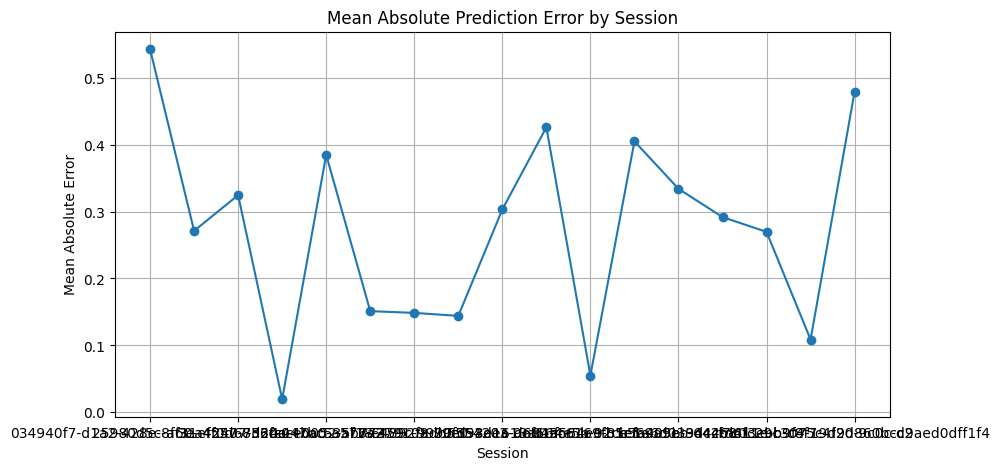

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Put predictions back to test dataframe for session-wise analysis
test_df = X_test.copy()
test_df['session'] = df.loc[X_test.index, 'session']
test_df['actual_boredom'] = y_test
test_df['predicted_boredom'] = y_pred
test_df['abs_error'] = np.abs(test_df['actual_boredom'] - test_df['predicted_boredom'])

# Calculate mean absolute error per session
session_error = test_df.groupby('session')['abs_error'].mean()

plt.figure(figsize=(10, 5))
session_error.plot(marker='o')
plt.title('Mean Absolute Prediction Error by Session')
plt.xlabel('Session')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.show()


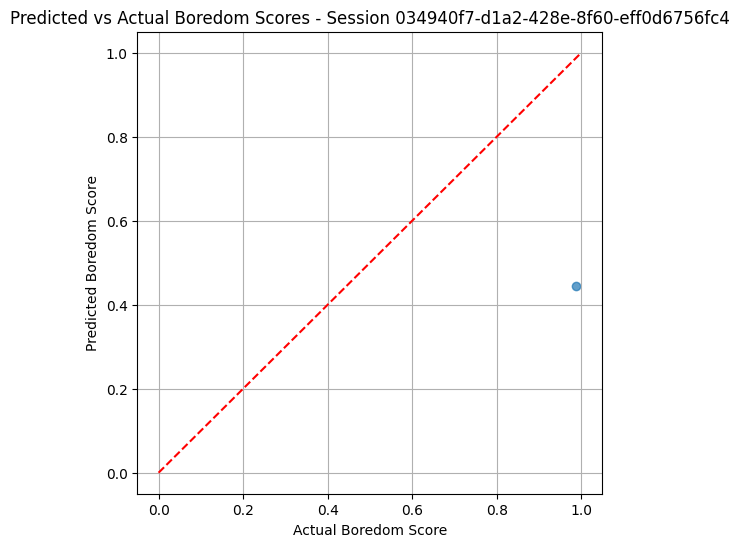

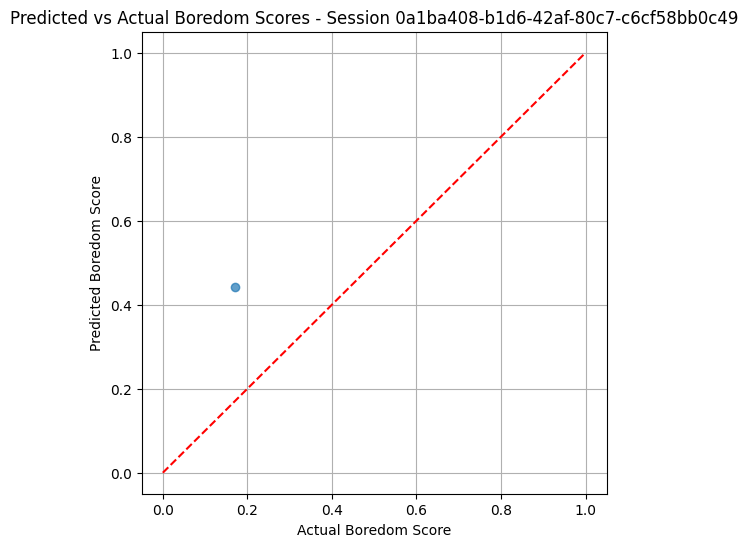

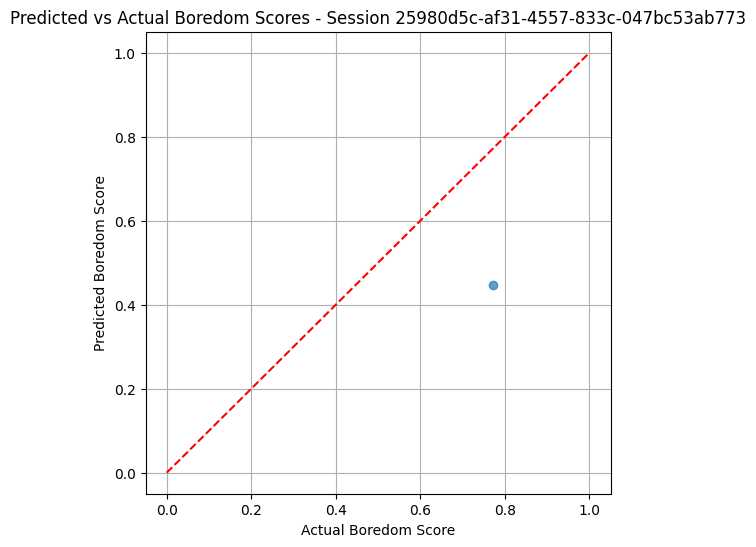

In [47]:
sessions_to_plot = session_error.index[:3]  # plot first 3 sessions as example

for session_id in sessions_to_plot:
    session_data = test_df[test_df['session'] == session_id]
    plt.figure(figsize=(6, 6))
    plt.scatter(session_data['actual_boredom'], session_data['predicted_boredom'], alpha=0.7)
    plt.plot([0, 1], [0, 1], 'r--')  # perfect prediction line
    plt.title(f'Predicted vs Actual Boredom Scores - Session {session_id}')
    plt.xlabel('Actual Boredom Score')
    plt.ylabel('Predicted Boredom Score')
    plt.grid(True)
    plt.show()
